In [1]:
%%sql -d standard
SELECT
  timestamp,
  borough,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
ORDER BY
  timestamp DESC
LIMIT
  15

timestamp,borough,latitude,longitude
2017-02-21 23:55:00,BRONX,40.883343,-73.8499
2017-02-21 23:47:00,,,
2017-02-21 23:41:00,BROOKLYN,,
2017-02-21 22:58:00,,,
2017-02-21 22:35:00,,,
2017-02-21 22:15:00,BROOKLYN,40.65136,-73.86971
2017-02-21 22:07:00,BROOKLYN,40.676952,-73.888596
2017-02-21 22:03:00,BROOKLYN,40.63593,-74.007195
2017-02-21 21:50:00,,40.803627,-73.963394
2017-02-21 21:50:00,BROOKLYN,40.626545,-73.94101


In [2]:
%%sql --module nyc_collisions
SELECT
  IF(borough = 'MANHATTAN', 1, 0) AS is_mt,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  LENGTH(borough) > 0 AND latitude IS NOT NULL AND longitude IS NOT NULL AND borough != "BRONX"
ORDER BY
  RAND()
LIMIT
  10000

In [3]:
import datalab.bigquery as bq
nyc_cols = bq.Query(nyc_collisions).to_dataframe(dialect='standard').as_matrix()
print "Found " + str(len(nyc_cols)) + " records."

Found 10000 records.


In [4]:
import numpy as np
is_mt = nyc_cols[:,0].astype(np.int32)
latlng = nyc_cols[:,1:3].astype(np.float32)
print "Is Manhattan: " + str(is_mt)
print "\nLat/Lng: \n\n" + str(latlng)

Is Manhattan: [0 0 0 ..., 1 0 0]

Lat/Lng: 

[[ 40.75118256 -73.85191345]
 [ 40.67910385 -73.98738861]
 [ 40.74560165 -73.86808777]
 ..., 
 [ 40.71523285 -74.01335144]
 [ 40.67562485 -73.89878082]
 [ 40.69528961 -73.94338989]]


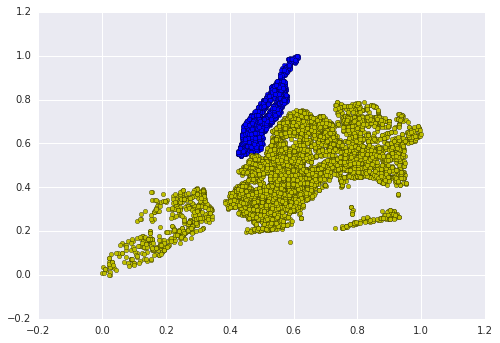

In [5]:
# standardization
from sklearn.preprocessing import MinMaxScaler
latlng_std = MinMaxScaler().fit_transform(latlng)

# plot
import matplotlib.pyplot as plt
lat = latlng_std[:,0]
lng = latlng_std[:,1]
plt.scatter(lng[is_mt == 1], lat[is_mt == 1], c='b')
plt.scatter(lng[is_mt == 0], lat[is_mt == 0], c='y')
plt.show()

In [6]:
# for training
latlng_train = latlng_std[0:7999]
is_mt_train = is_mt[0:7999]

# for test
latlng_test = latlng_std[8000:9999]
is_mt_test = is_mt[8000:9999]

In [7]:
import tensorflow as tf

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=2)]
lc = tf.contrib.learn.LinearClassifier(feature_columns)
lc.fit(x=latlng_train, y=is_mt_train, steps=2000)
print('Accuracy: ' + str(lc.evaluate(x=latlng_test, y=is_mt_test)["accuracy"]))

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


Accuracy: 0.950475


Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.


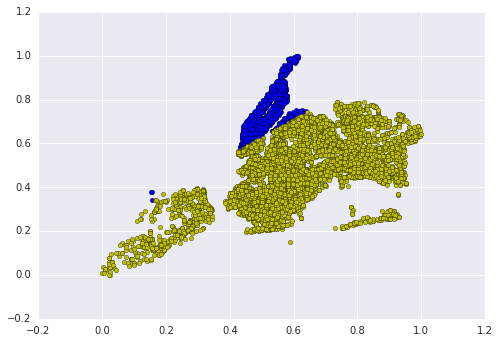

In [8]:
is_mt_pred = lc.predict(latlng_std)

plt.scatter(lng[is_mt_pred == 1], lat[is_mt_pred == 1], c='b')
plt.scatter(lng[is_mt_pred == 0], lat[is_mt_pred == 0], c='y')
plt.show()

In [11]:
dnnc = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[20, 20, 20],
                                            n_classes=3,
                                            model_dir="/tmp/mt_model_dnnc6")
for i in range (1, 5):
  dnnc.fit(x=latlng_train, y=is_mt_train, steps=500)
  print('Accuracy: ' + str(dnnc.evaluate(x=latlng_test, y=is_mt_test)["accuracy"]))

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


Accuracy: 0.973487


Accuracy: 0.978989


Accuracy: 0.997499


Accuracy: 0.998999


Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.


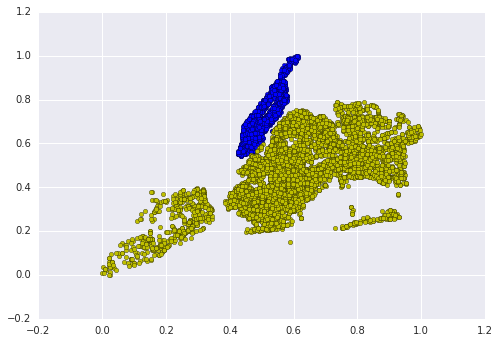

In [12]:
is_mt_pred = dnnc.predict(latlng_std)

plt.scatter(lng[is_mt_pred == 1], lat[is_mt_pred == 1], c='b')
plt.scatter(lng[is_mt_pred == 0], lat[is_mt_pred == 0], c='y')
plt.show()